# Table of Contents 

* [I. Introduction](#1)


* [II. Methodology](#2)
    * [A. Data](#2a)
    * [B. Preparation](#2b)
    
    
* [III. Building the QA System](#3)
    * [A. Query Type 1: Bankrupt Companies](#3a)
    * [B. Query Type 2: GDP](#3b)
    * [B. Query Type 3: CEO](#3b)
    
    
* [IV. Answering Questions](#4)

    


* [V. Conclusion](#5)

***

# I. Introduction <a class="anchor" id="1"></a>

The following document describes a step by step process of building a QA (Question Answering) System that parses through 730 Business Insider articles from 2013 and 2014 and is capable answering the following questions:

1. **Which companies went bankrupt in month X of year Y?**
2. **What percentage of drop or increase in GDP is associated with X?**
3. **Who is the CEO of company X?**

By incorporating the scoring system of Elasticsearch, spaCy’s NER tagger, and other heuristic methods, the following QA system is successfully able to categorize queries and output relevant answers. 

Because of the heavy reliance on heuristic methods used to categorize queries, the system is limited in the types of questions it can intake, and how these questions are phrased. To search for relevant answers, the system also uses a “distance” metric that calculates how far a candidate answer is from the key word (given the context of the sentence) to measure relevance, which does not always lead to the most accurate and meaningful results. 

However, by also outputting the sentence in which the system was able to infer the answer from, users can determine for themselves whether the outputted answer makes sense. Based on some trial results, this system was capable of producing highly relevant answers in a relatively short amount of run time. 

The system inputted a corpus of .txt files of total of 730 Business Insider articles, taken from 2013 and 2014. The script is tailored to the format of these text files and will need to be adjusted if other articles are used. 

***

# II. Methodology <a class="anchor" id="2"></a>

## A. Data<a class="anchor" id="2a"></a>

The data used includes 730 .txt files including Business Insider articles from 2013 to 2014. These will be processed and compiled as a text corpus. Sample file below:

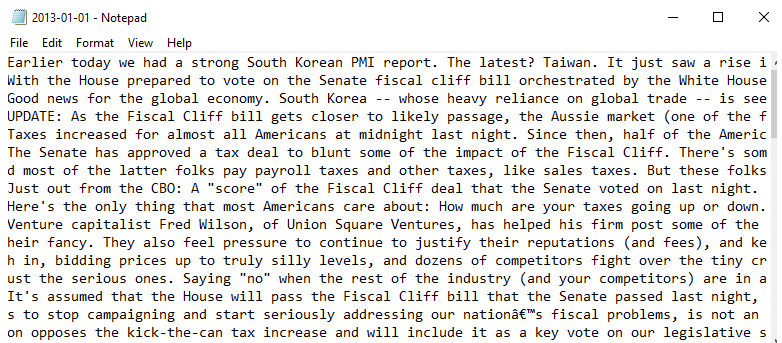

## B. Preparation<a class="anchor" id="2b"></a>

- I imported the 730 .txt files, combined the text into a corpus, and stored the corpus as a list of sentences using the `nltk.sent_tokenizer()` tool. 
- I then used **Elasticsearch**, an open source search and analytics engine. Inputting the list of tokenized sentences allowed Elasticsearch index each sentence as a separate document. 
    - Using these "documents," given an inputted list of keywords, elasticsearch scores each document according to its relevance to the keywords.
- For use in later steps, I created a master list of **stop words**, or words that don't typically add much contextual information to the text. 
    - I used `NLTK` package's list of stop words, as well as punctuation marks (except “%”).
- Finally, I created a function `find_distance()`, which inputs two words (or entities) and a sentence and outputs the “distance” between the two words based on their positions in the sentence. 


### 1. Importing Packages

In [20]:
import numpy as np
import pandas as pd
import glob
import nltk
from tqdm import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from elasticsearch import Elasticsearch
import string
from string import punctuation
import spacy
import en_core_web_sm
import re
from re import finditer
from collections import Counter

nlp = en_core_web_sm.load() # Spacy entity classifier

### 2. Loading Data

In [2]:
paths = ["2013/*.txt", "2014/*.txt"]
corpus = []
for path in paths:
    files = glob.glob(path)
    for name in files:
        try:
            with open(name,encoding='utf8', errors='ignore') as f:
                corpus.extend(f.readlines())
        except IOError as exc: 
            if exc.errno != errno.EISDIR: 
                raise
corpus = ''.join(corpus)

corpus_cleaned = corpus.replace("\\"," ").replace("\n"," ").replace('\xa0', " ") #
sentences = sent_tokenize(corpus_cleaned) # tokenizing text into sentences, and storing it as a variable

Indexing each sentence in the corpus in Elasticsearch.

**Warning: Takes ~2 hours to index and load each sentence in the corpus in Elasticsearch**

In [10]:
# Initializing Elasticsearch client
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
# indexing each sentence in the corpus in Elasticsearch
i = 0
for s in tqdm(sentences):
    es.index(index='sentences', doc_type = 'sentence', id=i, body={'sentence':s})
    i += 1

100%|██████████| 694806/694806 [1:46:29<00:00, 108.75it/s] 


### 3. Stop Words/Helper Function

In [178]:
sw = set(stopwords.words('english'))
for ch in punctuation:
    sw.update(ch)
sw.update(['Which','went','What','Who','associated'])
sw.remove('%')

`find_distance()` inputs two words and the sentence (a.k.a. document) these two words are in. Then, based on the positions of the words, the function outputs a numerical value that represents how far the words are apart from each other. If there are more than one occurrences of either of the two words, then the smallest "distance" is taken and outputted. 

In [298]:
def find_distance(w, kw, doc):
    pos_w = re.search(fr'{w}', str(doc)).start()
    distances = []
    for match in finditer(fr'{kw}', str(doc)):
        pos_kw = match.start()
        distances.append(abs(pos_w - pos_kw))
    return min(distances)

***
# III. Building the QA System<a class="anchor" id="3"></a>

## A. Query Type 1: Bankrupt Companies<a class="anchor" id="3a"></a>

**Query: Which companies went bankrupt in month X of year Y?**

The following helper function `answer_bankrupt()` **inputs a question** as a string and **outputs the answer**, as well as the sentence within the corpus where the answer is extracted from. 

The general objective would be to parse through sentences that is relevant with bankruptcy that contains the given month and the year, and output what the system has identified as a company. 

It follows the steps below:

#### 1. Storing Keywords from the Query
- The query is tokenized (separates them smaller units, e.g. words) and the stop words defined in [Section II B](#2B) are removed.
- Using `NLTK`'s part of speech (POS) tagger, each token is tagged with a part of speech. Then, the tokens tagged as proper nouns and dates are extracted.
- These tokens are then appended with key words "bankrupt" and "bankruptcy". The list of keywords are inputted in the variable `kw`, as well as in `date` which contains the date keywords (year, month).
    
    
#### 2. Extracting Relevant Sentences/Tokens from the Text Corpus
- The keywords from Step 1 are inputted in the Elasticsearch client to extract the 5000 most relevant sentences in the corpus
- The 5000 sentences are narrowed down by filtering them in the following criteria
    - The sentence contains the **year** specified in the query
    - The sentence contains the **month** specified in the query
    - The sentence contains the words **bankrupt** or **bankruptcy**
- Takes the relevant sentences and extracts three pieces of information for each sentence
    1. The token(s) in the sentence classifed as `ORG` by **SpaCy package**, which is an NER Tagging algorithm
    2. The index of the sentence in the `sentences` corpus variable associated with each of the relevant tokens
    3. The distance between the `ORG` tokens in the sentence and the word in the sentence that starts with `bankrupt`
    
#### 3. Selecting Final Answer
- A dataframe is created with the above 3 information, each instance representing a final answer candidate
- Candidate answers are sorted  by the associated "distance" from `bankrupt`.
   - **The crude assumption is that the closer the "distance," the more relevant answer the given token will be.**
- The top 10 instances of the token are chosen. There are likely duplicates, so the token that is the most frequently appearing is chosen as the final answer. 
- Outputs the final answer and the associated corpus snippet. 
    - If no candidate company was found, outputs an error message. 

In [299]:
def answer_bankrupt(q): # inputs a query
    
    # Step 1: Storing Keywords from the Query
    
    q_kw = [] # list to store keywords
    date = [] # list to store date keywords
    for w in word_tokenize(q): # for every word in the query 
        if w not in sw: # if it is not in the defined list of stop words
            q_kw.append(w) # append to our list of keywords
    q_tokens = nltk.pos_tag(q_kw) # tagging each word with a POS, creating list of tokens
    kw = ['bankrupt', 'bankruptcy']
    for i in range(len(q_tokens)): 
        pos = q_tokens[i][1] 
        if (pos == 'NNP') or (pos == 'CD'):
            kw.append(q_tokens[i][0])
            date.append(q_tokens[i][0])
    date = sorted(date) 
    
    # Step 2: Extracting Relevant Sentences/Tokens
    
    # runs Elasticsearch to find top 5000 relevant sentences
    companies_search = es.search(index='sentences',q=kw, size = 5000)

    candidates_org = [] # A. List to store candidate entities (companies)
    candidates_indices = [] # B. list to store document index in the corpus associated with each entity
    distances = [] # C. List to store "distance" between each entity and key word within the document
    for i in tqdm(range(len(companies_search['hits']['hits']))): # parses through the top 5000 relevant sentences from the corpus
        hasYear = False
        hasMonth = False
        hasBankrupt = False
        currSentence = companies_search['hits']['hits'][i]['_source']['sentence'] # extracts sentence from the corpus
        tokens = word_tokenize(currSentence) # tokenizing the sentence from the corpus
        if date[0] in tokens: # does the sentence have the year from the query?
            hasYear = True
        if date[1] in tokens: # does the sentence have the month from the query?
            hasMonth = True
        for w in ['bankrupt', 'bankruptcy']:
            if w in tokens:
                hasBankrupt = True # does the sentence have the words "bankrupt" or "bankruptcy"?
        doc = nlp(currSentence) #running Spacy entity tagger on the sentence
        if (hasMonth and hasYear and hasBankrupt): #ensures 3 criteria are met
            for ent in doc.ents:
                if (ent.label_ == "ORG"): #only handles entities tagged as "ORG" (organization)
                    candidates_org.append(str(ent)) # storing candidate answers
                    candidates_indices.append(int(companies_search['hits']['hits'][i]['_id'])) # storing the index number of the candidate entity's associated document
                    distances.append(find_distance(str(ent), 'bankrupt', doc)) # measures distance from 'bankrupt' in the sentence
            
    # Step 3: Selecting Final Answer

    if (candidates_org == []): # if no candidate answers were found
        print("Could not find an answer in the Business Insider Database. Try a different query.")
    else:
        # create dataframe for candidate entity, the associated sentence's index in the corpus, and distance
        df = pd.DataFrame(zip(candidates_org, candidates_indices, distances), columns=['candidates_org', 'candidates_indices', 'distances'])
        df = df.sort_values(by='distances').reset_index(drop=True).head(10) #takes entities with top 10 lowest distance
        final_candidates_org = df['candidates_org']
        final_candidates = sorted(Counter(final_candidates_org).items(), key=lambda x: x[1], reverse=True) #final candidates
       
        final_answer = final_candidates[0][0] 
        final_sentence_idx = df.loc[df['candidates_org']==final_answer].reset_index(drop=True)['candidates_indices'][0]
        final_sentence = sentences[final_sentence_idx]
        print(f'{final_answer}.\n\nSource Sentence: {final_sentence}') #outputting final answer and associated sentence in the corpus

## B. Query Type 2: GDP<a class="anchor" id="3b"></a>

**Type 2: What percentage of drop or increase is associated with Factor X?**

The following helper function `answer_gdp_percent()` inputs a question as a string and outputs the answer, as well as the sentence within the corpus where the answer is extracted from. It follows the steps below:

#### 1. Storing Keywords
- A list of manually curated keywords relevant to the question is created, as well as a list of keywords associated with an increase in percentage, and a list of keywords associated with a decrease in percentage. 
- The last word of the query "X" is stored as the keyword. If Factor X is inputted, the function will attempt to find the relevant % change associated with factor X.

    
#### 2. Extracting Relevant Sentences/Tokens
- The keywords from Step 1 is inputted in the Elasticsearch client to extract 1000 most relevant sentences from the corpus.
- The 1000 sentences are narrowed down by the following criteria
    - The sentence contains the word **GDP** in the query
    - The sentence contains any of the words in either increase or decrease keywords lists (`increase_kw` and `decrease_kw`)
    - The sentence contains the word representing factor X `q_kw`
- The relevant sentences are taken and three pieces of information for each sentence are extracted
    1. The token(s) in the sentence classifed as `PERCENT` by SpaCy
    2. The indices of the sentence in the `sentences` corpus variable associated with each of the relevant tokens
    3. The distance between the `PERCENT` tokens in the sentence and the word `GDP` in the sentence.
    
    
#### 3. Selecting Final Answer
- A dataframe is created with the above 3 information, each observation representing a possible `PERCENT` token, or a final answer candidate
- The candidate answers are sorted by the associated "distance" from `GDP`.
   - **The crude assumption is that the closer the "distance" our candidate answer is to the word "`GDP`," the more relevant answer the candidate answer will be.**
- Top 10 of these candidate answers are taken (they are already sorted by relevance from ElasticSearch). There are likely duplicates, so the candidate answer with the greater `distance` is dropped. 
- The top candidate answer is stored as well as the associated corpus snippet. 
    - If no candidate percentages were found, outputs an error message.


#### 4. Determining whether the percentage is associated with an increase or a decrease
- Step 3 should output a percentage associated with factor X (Factor X causes a change of Y percent in the GDP), but we don't know if it's an increase or a decrease. 
- As the final step, the function uses the `increase_kw` and `decrease_kw` lists of keywords (as defined earlier), and examines the sentence associated with the final answer to determine if the percent signifies an increase or a decrease.
    - Distance is calculated between the token representing the final answer and any words that exist in the sentence from the above defined `increase_kw` and `decrease_kw` lists. The token with the lowest "distance" from these lists is chosen. 
    - If this token is in `increase_kw`, the function categorizes our answer as an "increase", if this token is in `decrease_kw`, the function categorizes our answer as a "decrease." 
    
    
    
- The final output includes 
    - The final percentage answer
    - "increase" or "decrease"
    - Associated sentence

In [292]:
def answer_gdp_percent(q):
    
    # Step 1: Storing Keywords from Query
    
    # defining keywords
    kw = ['GDP','increase','decrease','%', 'decline','percent','drop','up','down','increased', 'grew', 'decreased','dropped','growth']
    increase_kw = ['increase', 'up', 'increased', 'growth', 'grew']
    decrease_kw = ['decrease', 'drop', 'dropped', 'down', 'decreased', 'decline', 'declined', 'shrank']
    # taking the last word
    q_kw = q.split()[-1][:-1]
    # if Factor X is government spending, take both words in as keyword
    if 'government spending' in q:
        q_kw = "government spending"
    kw.append(q_kw) # list of keywords
    
    # Step 2: Extracting Relevant Sentences/Tokens
    
    gdp_search = es.search(index='sentences',q=kw, size = 1000)
    candidates_percent = [] # A. List to store candidate entities (percentages)
    candidates_indices = [] # B. list to store indices associated with each entity
    distances = [] # C. List to store "distance" between each entity and 'GDP'
    
    for i in tqdm(range(len(gdp_search['hits']['hits']))):
        hasGDP = False
        hasKW = False
        hasIncrease = False
        hasDecrease = False
        # extracting sentence
        currSentence = gdp_search['hits']['hits'][i]['_source']['sentence'].replace("-","").replace("+","")
        tokens = word_tokenize(currSentence) # tokenizing
        tokens = [w for w in tokens if not w in sw] # removing stop words
        # defining booleans
        if 'GDP' in tokens:
            hasGDP = True
        if q_kw in tokens:
            hasKW = True
        for w in increase_kw:
            hasIncrease = True
        for w in decrease_kw:
            hasDecrease = True
        doc = nlp(currSentence) # Running Spacy entity tagger
        if hasGDP and hasKW and (hasIncrease or hasDecrease): # if criteria is met, append candidates
            for ent in doc.ents:
                if ent.label_ == "PERCENT":
                    candidates_percent.append(str(ent)) 
                    candidates_indices.append(int(gdp_search['hits']['hits'][i]['_id']))
                    distances.append(find_distance(str(ent), 'GDP', doc))

    # Step 3: Selecting Final Answer
    
    if (candidates_percent == []): # if no candidates were found, output error message
        print("Could not find an answer in the Business Insider Database. Try a different query.")
    else:
        # creating a dataframe with all of the candidate answers and their associated indices/distances
        df = pd.DataFrame(zip(candidates_percent, candidates_indices, distances), columns=['candidates_percent', 'candidates_indices', 'distances'])
        df = df.head(10) # takes top 10 
        df = df.sort_values(by='distances').head(10) # sort them by distance
        df = df.drop_duplicates(subset=['candidates_indices'], keep='first') # dropping duplicates, storing the one with the lowest distance
        df = df.sort_index().reset_index(drop=True)
        final_answer = df['candidates_percent'][0] # extracting final answer
        final_sentence = sentences[df['candidates_indices'][0]] # extracting final sentence

    # Step 4: Determining if the % represents an increase or a decrease 
    
        increase_distances = [] # list to store distances between % answer and "increase" related words
        decrease_distances = [] # list to store distances between % answer and "decrease" related words
        for w in increase_kw:
            if w in final_sentence:
                increase_distances.append(find_distance(w, final_answer, final_sentence))
        for w in decrease_kw:
            if w in final_sentence:
                decrease_distances.append(find_distance(w, final_answer, final_sentence))
        increase_or_decrease = ''
        # the keyword with the smallest distance informs whether to categorize answer as "increase" or "decrease"
        if (len(increase_distances)>0) and (len(decrease_distances)>0):
            if min(increase_distances) <  min(decrease_distances):
                increase_or_decrease = 'increase'
            else:
                increase_or_decrease = 'decrease'
        else:
            if len(increase_distances) > 0:
                increase_or_decrease = 'increase'
            else:
                increase_or_decrease = 'decrease'

        final_answer = final_answer + ' ' + increase_or_decrease
        
        # Outputting final answer, "increase" or "decrease", and the associated sentence in the corpus
        print(f'{final_answer}.\n\nSource Sentence: {final_sentence}')


## C. Query Type 3: CEO<a class="anchor" id="3c"></a>

**Who is the CEO of Company X?**

The following helper function `answer_ceo()` inputs a question as a string and outputs the answer, as well as the sentence within the corpus where the answer is extracted from. It follows the steps below:

#### 1. Storing keywords
- Tokenizes the query and removes stop words.
    
    
#### 2. Extracting Relevant Sentences/Tokens
- The keywords from Step 1 is inputted in the Elasticsearch client to extract the 500 most relevant sentences
- Takes the relevant sentences and extracts two pieces of information for each sentence
    1. The token(s) in the sentence classifed as `PERSON` by SpaCy
    2. The indices of the sentence in the `sentences` corpus variable associated with each of the relevant tokens
    - `PERSON` is relatively less frequent than other types, so I found it not necessary to use `distance` as a measure to choose the final answer 

    
#### 3. Selecting Final Answer
- Creates a dataframe with the above 2 pieces of information, each observation representing a `PERSON` token, or a final answer candidate for the CEO.
- There are likely duplicates of the CEOs, so chooses the token that is the most frequently appearing as the final answer. 
- Outputs the final answer and the associated corpus snippet. 
    - If no candidate CEOs were found, outputs an error message.

In [300]:
def answer_ceo(q):
    
    # Step 1: Storing Keywords from Query
    
    q_kw = []
    for w in word_tokenize(q):
        if w not in sw:
            q_kw.append(w)

    # Step 2: Extracting Relevant Sentences/Tokens
    
    # runs Elasticsearch to find top 500 relevant sentences
    ceo_search = es.search(index='sentences',q=q_kw, size = 500)

    candidates_ceo = [] #A. list to store candidate entities (ceo)
    candidates_indices = [] #B. list to store indices associated with each entity

    for i in tqdm(range(len(ceo_search['hits']['hits']))):
        currSentence = ceo_search['hits']['hits'][i]['_source']['sentence'] # extracts sentence
        doc = nlp(currSentence) #running Spacy entity tagger
        for ent in doc.ents:
            if (ent.label_ == "PERSON"): #only handles entities tagged as "PERSON" 
                candidates_ceo.append(str(ent))
                candidates_indices.append(int(ceo_search['hits']['hits'][i]['_id']))

    # Step 3: Selecting Final Answer

    if (candidates_ceo == []): # if no candidate answers were found
        print("Could not find an answer in the Business Insider Database. Try a different query.")
    else:
        # create dataframe for candidate entity and the associated sentence's index in the corpus
        df = pd.DataFrame(zip(candidates_ceo, candidates_indices), columns=['candidates_ceo', 'candidates_indices'])
        final_candidates_ceo = list(df['candidates_ceo'])
        final_candidates = sorted(Counter(final_candidates_ceo).items(), key=lambda x: x[1], reverse=True)
        
        final_answer = final_candidates[0][0]
        final_sentence_idx = df.loc[df['candidates_ceo']==final_answer].reset_index(drop=True)['candidates_indices'][0]
        final_sentence = sentences[final_sentence_idx]
        print(f'{final_answer}.\n\nSource Sentence: {final_sentence}') #outputting final answer and associated sentence in the corpus

***
# IV. Answering Questions<a class="anchor" id="4"></a>

Below are two helper functions to categorize our query heuristically and use the appropriate function from above. 


The function `classify_question()` takes in a query and categorizes the query using the following criteria.
- The bankruptcy question if the word **bankrupt** is present in the query
- The GDP question if the word **percentage** is present in the query
- The CEO oquestion if the word **CEO** is present in the query

The function `answer()` takes in a query and based on the classification of the query, calls the appropriate function to answer the question. 
- If the question is in none of the above 3 categories, prints an error message.

In [302]:
def classify_question(q):
    q_type = 0
    if 'bankrupt' in q:
        q_type = 1
    elif 'percentage' in q:
        q_type = 2
    elif 'CEO' in q:
        q_type = 3
    return q_type
def answer(q):
    if classify_question(q) == 0:
        print("Please ask a different question.")
    if classify_question(q) == 1:
        print(answer_bankrupt(q))
    if classify_question(q) == 2:
        print(answer_gdp_percent(q))
    if classify_question(q) == 3:
        print(answer_ceo(q))

## A. Bankruptcy Question

In [307]:
answer("Which companies went bankrupt in month September of year 2008?")

100%|██████████| 5000/5000 [00:35<00:00, 141.97it/s]

Lehmann Brothers.

Source Sentence: The reversal began in 2008, but it accelerated in the Fall of that year following the September 15th bankruptcy of Lehmann Brothers.
None


In [308]:
answer("Which companies went bankrupt in month June of year 2009?")

100%|██████████| 5000/5000 [00:35<00:00, 142.17it/s]

Delphi Holdings LLC.

Source Sentence: The Internal Revenue Service told Delphi in June that it would be taxed as a U.S. company due to the sale of its assets to Delphi Holdings LLC after it emerged from bankruptcy in 2009, the company said in a regulatory filing on July 31.
None


In [309]:
answer("Which companies went bankrupt in month November of year 2011?")

100%|██████████| 5000/5000 [00:35<00:00, 140.49it/s]

US Airways.

Source Sentence: American, a unit of AMR Corp, filed for Chapter 11 bankruptcy in November 2011, and US Airways began its pursuit of a merger in early 2012.
None


In [325]:
answer("Which companies went bankrupt in month November of year 2010?")

100%|██████████| 5000/5000 [00:37<00:00, 132.99it/s]

Could not find an answer in the Business Insider Database. Try a different query.
None


## B. GDP Question

In [317]:
answer("What percentage of drop or increase in the GDP is associated with consumption?")

100%|██████████| 1000/1000 [00:07<00:00, 142.12it/s]

2 percentage points increase.

Source Sentence: Personal consumption grew by 3.0%, adding 2 percentage points of growth to GDP.
None


In [318]:
answer("What percentage of drop or increase in the GDP is associated with investment?")

100%|██████████| 1000/1000 [00:06<00:00, 144.37it/s]

2.1 percent decrease.

Source Sentence: In the first quarter, real GDP decreased 2.1 percent (revised)...The increase in real GDP in the second quarter primarily reflected positive contributions from personal consumption expenditures (PCE), private inventory investment, exports, nonresidential fixed investment, state and local government spending, and residential fixed investment.
None


In [319]:
answer("What percentage of drop or increase in the GDP is associated with exports?")

100%|██████████| 1000/1000 [00:06<00:00, 146.47it/s]

2.1 percent decrease.

Source Sentence: In the first quarter, real GDP decreased 2.1 percent (revised)...The increase in real GDP in the second quarter primarily reflected positive contributions from personal consumption expenditures (PCE), private inventory investment, exports, nonresidential fixed investment, state and local government spending, and residential fixed investment.
None


## C. CEO Question

In [320]:
answer("Who is the CEO of Tesla?")

100%|██████████| 500/500 [00:03<00:00, 156.62it/s]

Elon Musk.

Source Sentence: Tesla is here to stay and keep fighting for the electric car revolution," said Elon Musk, Tesla Motors co-founder and CEO.
None


In [321]:
answer("Who is the CEO of Apple?")

100%|██████████| 500/500 [00:03<00:00, 163.99it/s]

Tim Cook.

Source Sentence: The Apple Watch will be the first major Apple product to launch under CEO Tim Cook.
None


In [322]:
answer("Who is the CEO of Starbucks?")

100%|██████████| 500/500 [00:03<00:00, 155.19it/s]

Howard Schultz.

Source Sentence: Starbucks CEO Howard Schultz has been particularly tough on Ackman in public.
None


***
# V. Conclusion<a class="anchor" id="5"></a>

For all the question types, the QA system was able to produce results that were more or less accurate. The system did the best job answering CEO related questions, and the worst answering bankruptcy questions. The bankruptcy questions took in average 35-40 seconds to answer the question, the GDP questions took about 6-7 seconds, and CEO questions took about 3 seconds. Although this method adequately answered some of these questions, a lot of information is left out during the filtering process.

For next steps, it would be interesting to add onto the pipeline and incorporate more machine learning in order to classify the questions and select candidate answers. Some of the methods I am using are purely heuristic (measuring “distance” between words to calculate relevancy, filtering candidate sentences based on the keywords that they contain, etc.). I am also completely relying on the spaCy NER classifier to select out some of the key words, which is not always accurate. The classifier could be modified with my own machine learning models.
